## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import time

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from xgboost import XGBClassifier

from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler


## Exploratory data analysis

In [2]:
# Dataset source - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify the path to your CSV file in Google Drive
file_path = '/content/drive/My Drive/5_MS_DataScience_UOA/Assignments/CC_Data/creditcard.csv'
#print(file_path)

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
df.head()

Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#observe the different feature type present in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# Checking for the missing value present in each columns
df.isnull().sum().sort_values(ascending = False)

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64

#### Observation : There is no missing value present in the dataset.

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Observation : The 28 V columns are in the same scale. Amount and Time needs to be scaled.

Here we will observe the distribution of our classes

In [6]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

print("Class Distribution is : ")
print(classes)
print("Percentage of Normal Transactions is : ", normal_share)
print("Percentage of Fraud Transactions is : ", fraud_share)

Class Distribution is : 
0    284315
1       492
Name: Class, dtype: int64
Percentage of Normal Transactions is :  99.82725143693798
Percentage of Fraud Transactions is :  0.1727485630620034


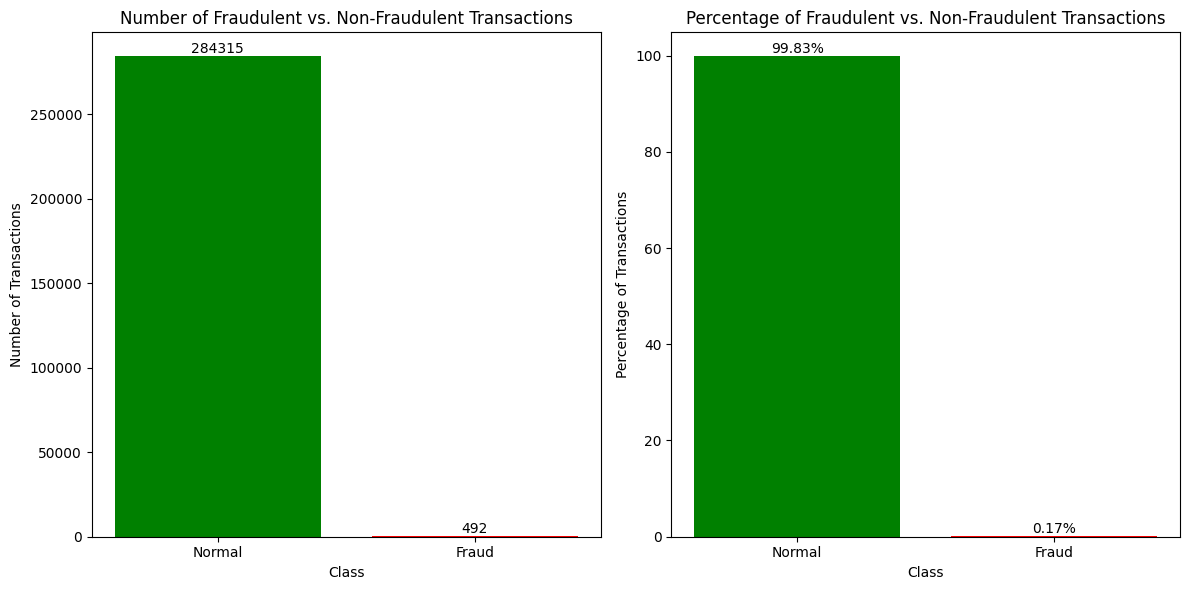

In [7]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Create a bar plot for the number of transactions
axes[0].bar(['Normal', 'Fraud'], classes.values, color=['green', 'red'])
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_title('Number of Fraudulent vs. Non-Fraudulent Transactions')

# Print values on top of the bars
for i, v in enumerate(classes.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# Create a bar plot for the percentage distribution
axes[1].bar(['Normal', 'Fraud'], [normal_share, fraud_share], color=['green', 'red'])
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Percentage of Transactions')
axes[1].set_title('Percentage of Fraudulent vs. Non-Fraudulent Transactions')
# Print values on top of the bars
for i, v in enumerate([normal_share, fraud_share]):
    axes[1].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

# Show the subplots side by side
plt.tight_layout()
plt.show()


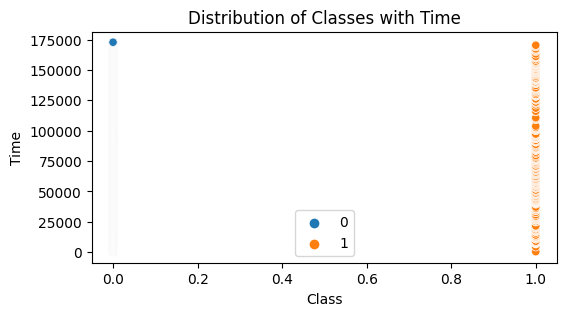

In [8]:
# Create a scatter plot to observe the distribution of classes with time

# Create a scatter plot
plt.figure(figsize=(6, 3))
sns.scatterplot(data=df, x='Class', y='Time', hue='Class')
plt.xlabel('Class')
plt.ylabel('Time')
plt.title('Distribution of Classes with Time')
plt.legend()
plt.show()


#### Observation : Fraud transactions are present across time

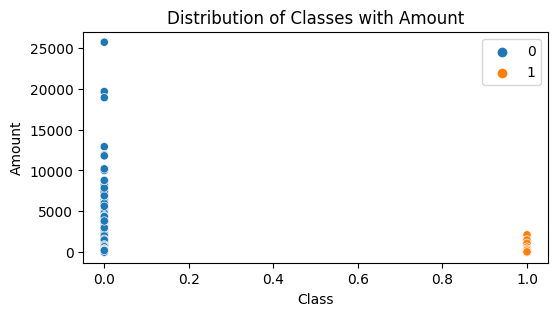

In [9]:
# Create a scatter plot to observe the distribution of classes with Amount

# Create a scatter plot
plt.figure(figsize=(6, 3))
sns.scatterplot(data=df, x='Class', y='Amount', hue='Class')
plt.xlabel('Class')
plt.ylabel('Amount')
plt.title('Distribution of Classes with Amount')
plt.legend()
plt.show()


#### Observation : Fraud transaction is present for lower transation values

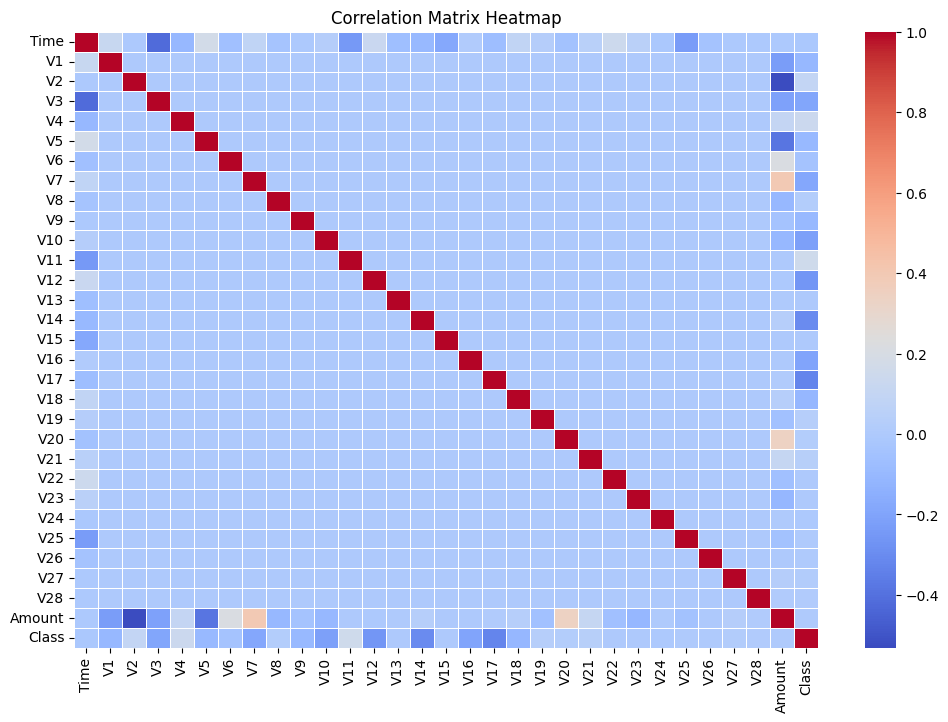

In [10]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap with color coding and legend
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")

plt.show()


#### Observation : There is no strong correlation between features

### Plotting the Distribution of the class for all features

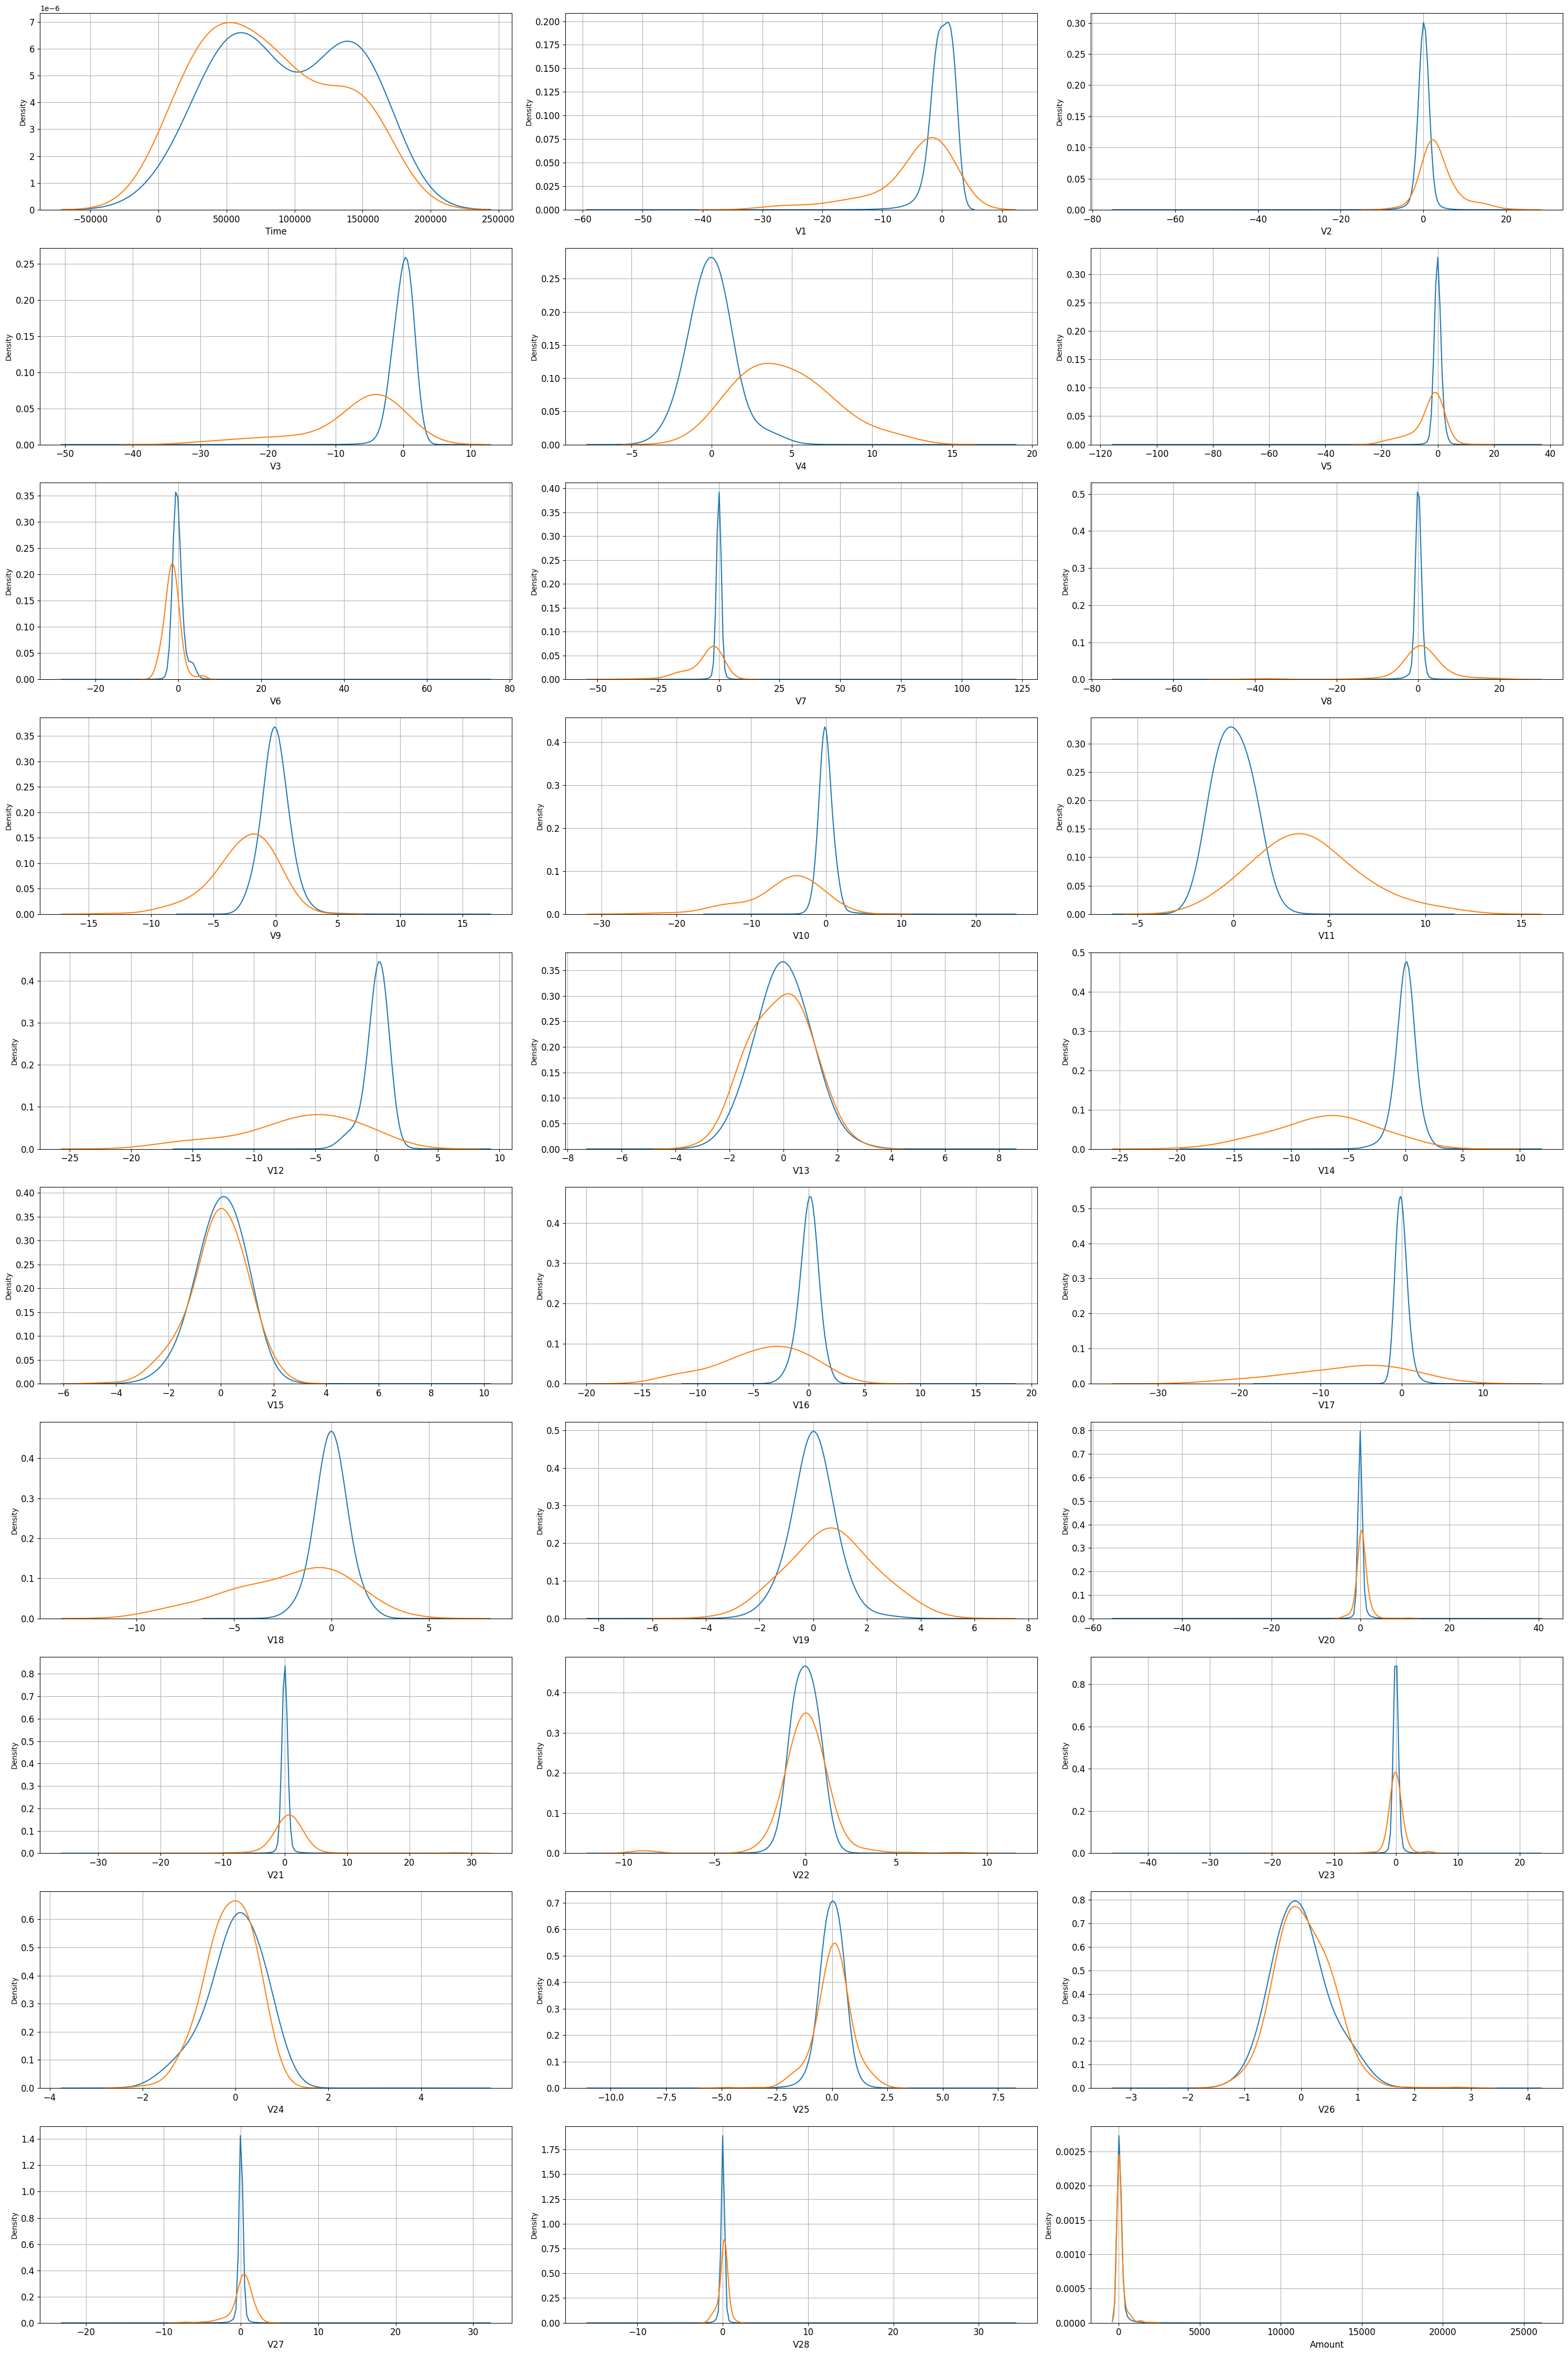

In [11]:
#import seaborn as sns
#import matplotlib.pyplot as plt
#import warnings

# Suppress warnings
#warnings.filterwarnings("ignore")

# Separate the data for each class
t0 = df[df['Class'] == 0]
t1 = df[df['Class'] == 1]

# List of numerical feature names (excluding 'Class')
features = df.drop(columns=['Class']).columns

# Set up subplots
fig, axes = plt.subplots(10, 3, figsize=(30, 45))
axes = axes.flatten()

# Plot distributions for each feature
for i, feature in enumerate(features):
    sns.kdeplot(data=t0[feature], bw_method=0.5, label="Class 0", ax=axes[i])
    sns.kdeplot(data=t1[feature], bw_method=0.5, label="Class 1", ax=axes[i])

    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].grid()

plt.tight_layout()
plt.show()


#### Observations : Most of the feature is overlapping for both of the classes. Time column can be dropped as it would not help with model building.

In [12]:
# Drop unnecessary columns
df = df.drop("Time", axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
#from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the 'Amount' column
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Now, the 'Amount' column is scaled
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


### Splitting the data into train & test data

In [14]:
#class variable

y= df["Class"]
X = df.drop("Class", axis = 1)
y.shape,X.shape

((284807,), (284807, 29))

In [15]:
#from sklearn import model_selection
#from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [16]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
356
59


### Plotting the distribution of a variable

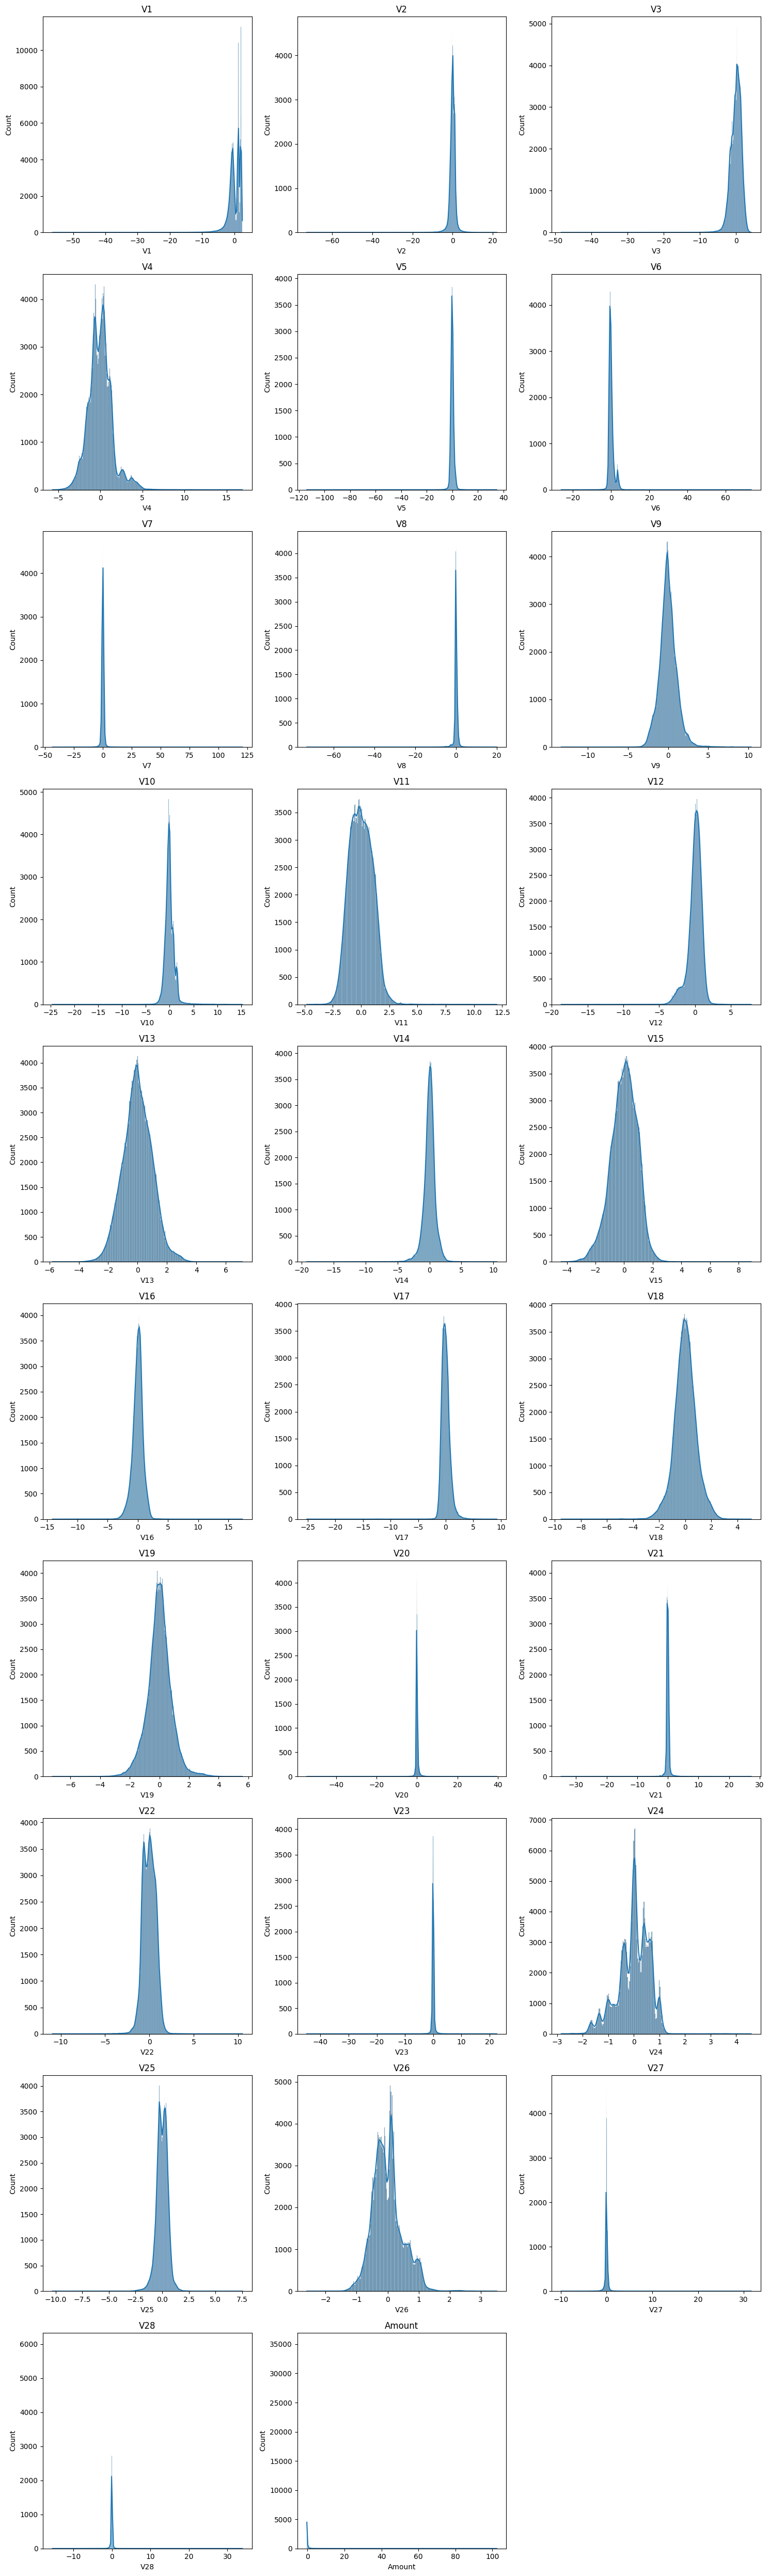

In [17]:
# plot the histogram of a variable from the dataset to see the skewness

# Get the column names
var = X_train.columns

# Calculate the number of rows and columns for subplots
num_cols = len(var)
num_rows = (num_cols - 1) // 3 + 1  # 3 columns per row

# Create subplots
plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(var, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(X_train[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()


#### Observation : Lot of features are highly skewed. So we will check the skewness using skew() and if the skewness is beyond -1 to 1, then we will use power transform to transform the data.

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [18]:
# Calculate skewness for each feature and store it in a DataFrame
skew_df = pd.DataFrame({'Features': X_train.columns, 'Skewness': X_train.skew()})
skew_df.set_index('Features', inplace=True)


In [19]:
skewed = skew_df[abs(skew_df['Skewness']) > 1].index.tolist()


In [20]:
#from sklearn.preprocessing import PowerTransformer

# preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
pt = PowerTransformer()

# Fitting the power transformer in train data
X_train[skewed] = pt.fit_transform(X_train[skewed])


# Transforming the test data
X_test[skewed] = pt.transform(X_test[skewed])

In [21]:
# Set options to display all columns and increase the column width
pd.set_option('display.max_columns', None)  # Set to None to display all columns
pd.set_option('display.width', None)  # Set to None to display without line wrapping
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
2557,-1.241353,-0.385254,0.489178,-1.706423,0.585093,-1.434760,0.755444,-0.575159,1.323156,-0.373335,0.330147,0.556799,0.112201,-0.306814,1.267783,-1.034046,-0.390481,-0.613436,-0.401911,-1.065434,-0.278406,0.914737,1.420050,0.422969,0.310584,-0.781488,0.392241,-0.451024,-1.039372
247823,-0.433397,-2.200645,-1.923197,0.704011,0.059097,1.156282,1.235385,-0.113416,0.015829,-0.299829,0.905251,0.711075,-0.283648,1.218429,0.549725,-0.639066,0.049790,-0.904567,-0.884600,2.773786,1.166283,-0.091941,-1.468632,-0.833081,-0.498728,0.651183,-0.290331,0.353031,2.083941
152342,-1.073938,-0.436806,1.888355,-0.960318,-0.872512,1.148117,-1.143510,0.909511,1.961027,-0.662840,-2.114621,-2.330414,1.215878,0.072119,-2.456654,-1.420706,1.192121,2.063020,-0.464144,-0.711416,-0.706887,-0.424978,-0.438848,0.010121,0.466862,0.835540,-0.062385,0.284620,0.748299
103385,0.628272,0.030733,-0.055561,0.459628,-0.050165,0.020225,-0.127955,0.078951,-0.067566,-0.078268,1.401227,0.314798,-0.751172,0.033003,0.771533,0.567416,-0.090600,-0.031356,-0.137183,-0.195187,-0.320434,-0.739862,0.175645,-0.373837,0.125470,0.130126,-0.016956,0.049453,-1.004414
8771,-0.740551,0.397798,0.736347,-1.547626,0.473227,0.492751,0.270460,0.198714,1.381880,-0.597925,1.093326,-2.065539,1.194529,1.892904,-0.486271,1.062177,-0.494578,0.479331,-0.470981,0.154362,-0.375984,-0.470181,-0.210440,-1.388839,-0.237453,0.785347,0.349708,0.675667,0.032832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.611887,-0.021268,0.214462,0.461596,-0.226517,-0.063211,-0.129058,0.041683,-0.114199,0.118605,1.585195,0.841709,-0.476319,0.616438,0.658885,0.209495,-0.457337,-0.410923,-0.182494,-0.204853,-0.243287,-0.574283,0.247956,-0.006140,0.091444,0.109235,-0.020922,0.024710,-1.004414
259178,-0.657762,0.007536,-0.854343,-1.241113,1.416784,2.471088,-0.371527,1.470306,0.400697,-0.591966,-0.421422,0.237095,-0.041877,0.356106,0.785702,-0.010000,-0.578432,-0.063197,0.094703,-0.381672,0.069159,-0.019575,0.378917,0.682820,-1.635109,-0.770941,0.066006,0.434762,0.938028
131932,-0.343063,0.615580,1.137456,0.485774,0.238757,-0.597743,0.860388,-0.446566,-0.491303,-0.157341,-0.382362,-0.154214,0.331641,-0.100958,0.690200,-0.244122,-0.666223,-0.068375,-0.229614,0.006266,0.090727,0.354089,-0.474311,0.402849,0.237383,-0.398467,-0.121139,-0.604672,-0.935590
146867,-1.453145,1.714225,-1.537307,-3.798905,1.361272,1.847358,-0.376100,2.607097,0.580199,0.018953,-0.418939,0.540315,-0.294107,1.027459,-0.090065,0.443807,-0.502569,-0.946837,-1.143752,0.534143,-0.451973,-1.047514,0.218620,0.678869,0.319710,0.426309,0.496912,1.035956,-1.039372


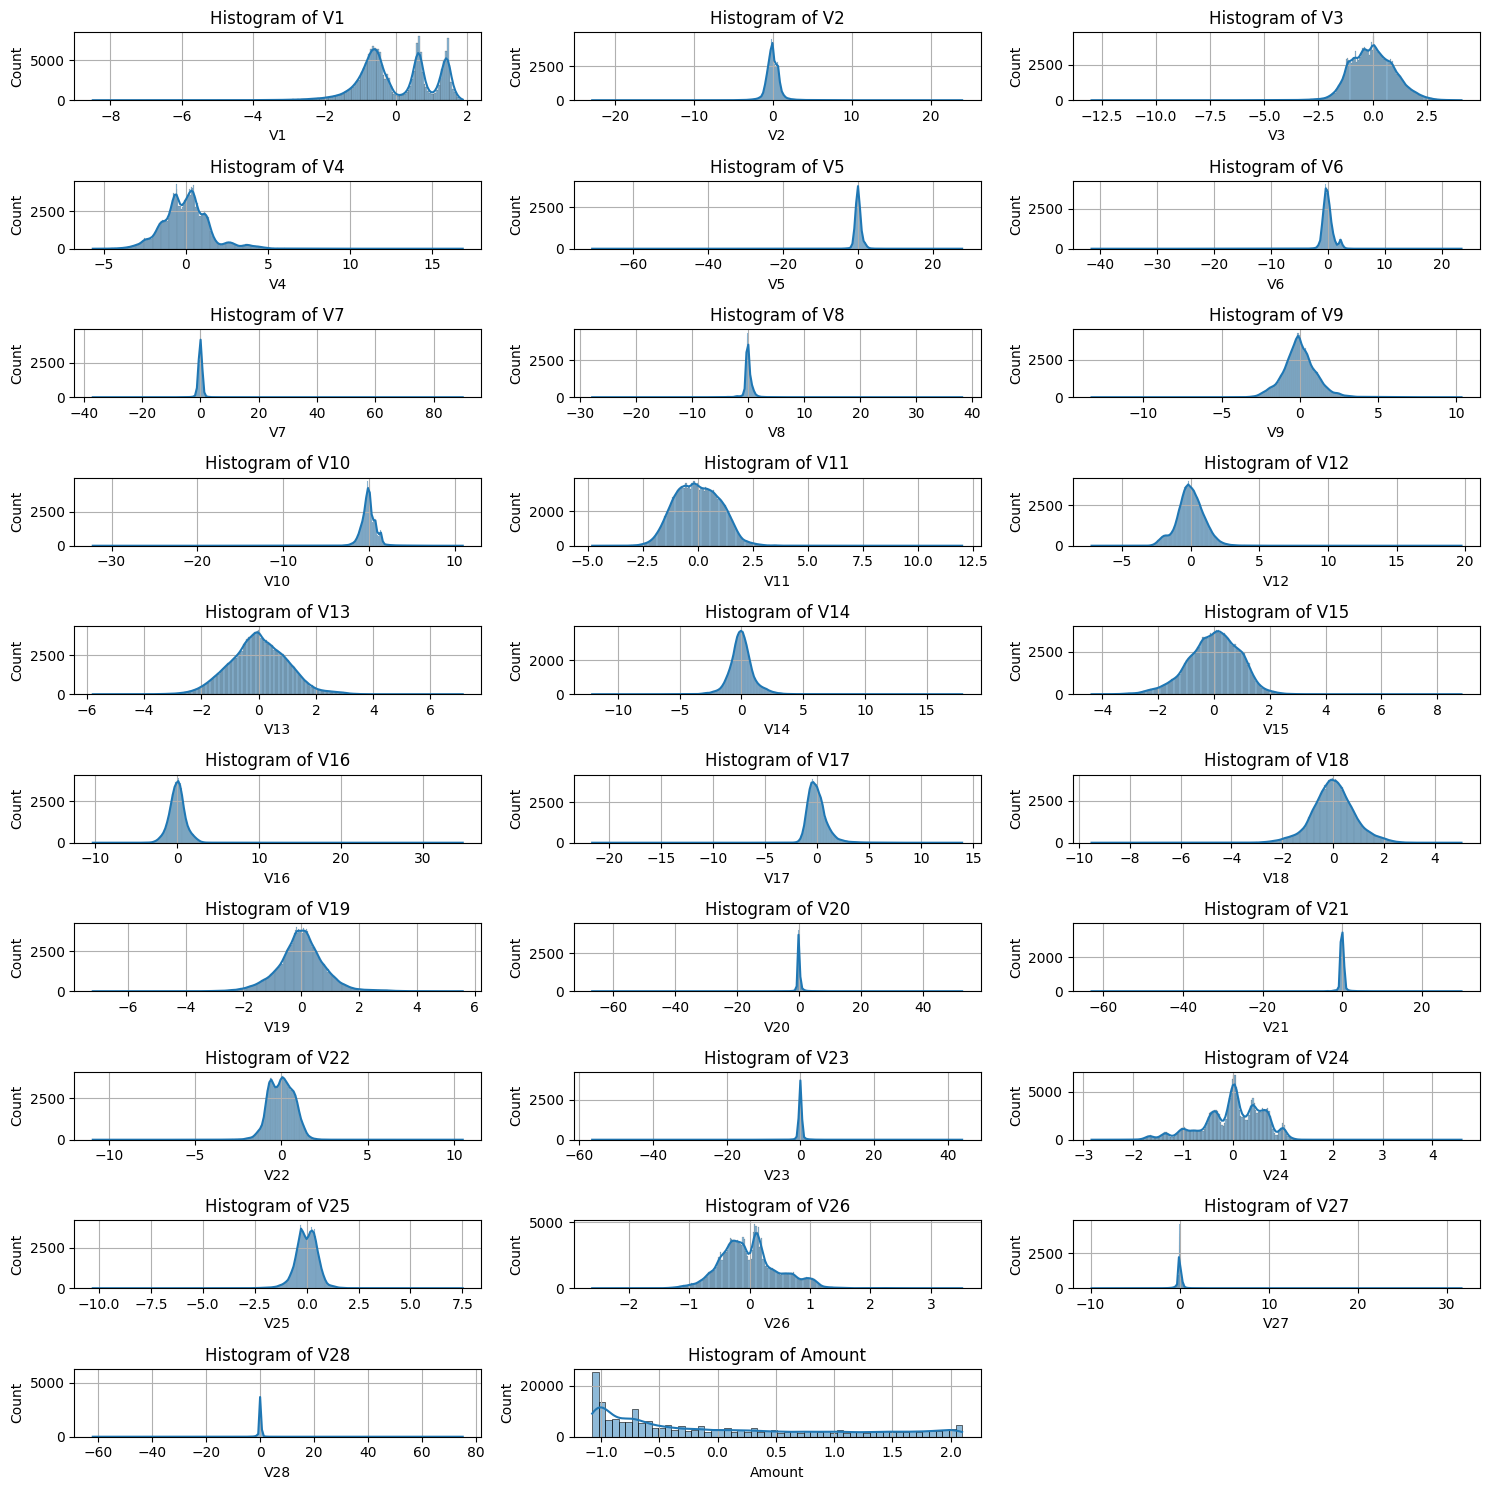

In [22]:
#import matplotlib.pyplot as plt

# Select the numerical columns you want to plot
numerical_columns = X_train.select_dtypes(include=['number']).columns

# Set the number of rows and columns for subplots
num_rows = len(numerical_columns) // 3 + 1
num_cols = 3

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes for easy iteration
axes = axes.ravel()

# Loop through numerical columns and plot histograms
for i, col in enumerate(numerical_columns):
    sns.histplot(X_train[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].grid()

# Remove any empty subplots
for i in range(len(numerical_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


## Model Building
- Build different models on the imbalanced dataset and see the result

In [23]:
# Logistic Regression
# from sklearn import linear_model #import the package

from sklearn import linear_model
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, f1_score, roc_auc_score


# List of values for hyperparameter 'C'
num_C = [0.001, 0.01, 0.1, 1, 10]

# List of values for cross-validation (cv)
cv_num = [3, 5, 7]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_score = 0.0

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv
- y_train_cv
- y_test_cv

In [24]:
#perform cross validation

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters

In [25]:

# from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score
# from tqdm import tqdm
# import time
# from sklearn.preprocessing import PowerTransformer

# code for hyperparameter tuning and modeling with Logistic Regression
models_to_explore = [
    {
        'model_name': 'LogisticRegression',
        'model': LogisticRegression(),
        'param_grid': {
            'C': [0.001, 0.01, 0.1, 1, 10],  # List of values for hyperparameter 'C'
        }
    },
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_roc_auc = 0.0

# Create a tqdm progress bar for hyperparameter tuning
progress_bar = tqdm(total=len(models_to_explore), desc="Exploring Models")

for model_info in models_to_explore:
    model_name = model_info['model_name']
    model = model_info['model']
    param_grid = model_info['param_grid']

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,  # Specify the number of cross-validation folds here
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Fit the model with hyperparameter tuning
    start_time = time.time()
    grid_search.fit(X_train, y_train)  # Replace with your actual variable names
    end_time = time.time()

    # Calculate execution time for this model exploration
    execution_time = end_time - start_time

    # Get the best model
    best_model_for_current = grid_search.best_estimator_

    # Evaluate the best model on the validation data
    y_pred = best_model_for_current.predict_proba(X_val)[:, 1]  # Replace with your actual variable names
    roc_auc = roc_auc_score(y_val, y_pred)  # Replace with your actual variable names

    print(f"{model_name} - ROC AUC on Validation Data: {roc_auc:.4f}")

    if roc_auc > best_roc_auc:
        best_model = best_model_for_current
        best_roc_auc = roc_auc

    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Train the best model on the full training data
best_model.fit(X_train, y_train)  # Replace with your actual variable names

# Evaluate the best model on the test data
y_pred = best_model.predict_proba(X_test)[:, 1]  # Replace with your actual variable names
roc_auc = roc_auc_score(y_test, y_pred)  # Replace with your actual variable names
print(f"Best Model ({best_model.__class__.__name__}) - ROC AUC on Test Data: {roc_auc:.4f}")


Exploring Models:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Exploring Models: 100%|██████████| 1/1 [00:06<00:00,  6.58s/it]

LogisticRegression - ROC AUC on Validation Data: 0.9863


Best Model (LogisticRegression) - ROC AUC on Test Data: 0.9886


### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

In [26]:
# import pandas as pd
# from sklearn.model_selection import cross_val_score
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# import xgboost as xgb
# import time

# List of models
models = [
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    #("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model commented during development phase as it runs longer
    ("XGBoost", xgb.XGBClassifier(random_state=42))
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_score = 0.0
best_params = None

# Initialize a list to store results
results = []

# Progress bar initialization
total_models = len(models)
current_model = 0

# Iterate through models
for model_name, model in models:
    current_model += 1
    print(f"Training {model_name} ({current_model}/{total_models})...")

    start_time = time.time()  # Record start time

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    end_time = time.time()  # Record end time
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Calculate mean ROC AUC score
    mean_score = scores.mean()

    print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

    # Check if this model is the best so far
    if mean_score > best_score:
        best_score = mean_score
        best_model = model_name
        best_params = model.get_params()  # Get the best hyperparameters

    # Store results in the list
    results.append({
        'model_name': model_name,
        'best_score': mean_score,
        'best_params': model.get_params(),
        'time_taken': elapsed_time
    })

print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")

# Create a dataframe from the results list
results_df = pd.DataFrame(results)

# Print the dataframe
print("\nResults DataFrame:")
print(results_df)


Training K-Nearest Neighbors (1/4)...
K-Nearest Neighbors - Mean ROC AUC: 0.9099, Time Taken: 43.60 seconds
Training Decision Tree (2/4)...
Decision Tree - Mean ROC AUC: 0.8747, Time Taken: 65.90 seconds
Training Random Forest (3/4)...
Random Forest - Mean ROC AUC: 0.9390, Time Taken: 649.33 seconds
Training XGBoost (4/4)...
XGBoost - Mean ROC AUC: 0.9755, Time Taken: 103.87 seconds

Best Model: XGBoost with ROC AUC score of 0.9755

Results DataFrame:
            model_name  best_score  \
0  K-Nearest Neighbors    0.909910   
1        Decision Tree    0.874706   
2        Random Forest    0.938966   
3              XGBoost    0.975530   

                                         best_params  time_taken  
0  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   43.598679  
1  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   65.903478  
2  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  649.328616  
3  {'objective': 'binary:logistic', 'use_label_en...  103.872570  


In [27]:
results_df

,model_name,best_score,best_params,time_taken
0,K-Nearest Neighbors,0.909910,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",43.598679
1,Decision Tree,0.874706,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",65.903478
2,Random Forest,0.938966,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",649.328616
3,XGBoost,0.975530,"{'objective': 'binary:logistic', 'use_label_en...",103.872570


**Observation** : XGBoost model is best performing model

#### Proceed with the model which shows the best result
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [28]:
# from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# from xgboost import XGBClassifier
# from sklearn.metrics import roc_auc_score
# from tqdm import tqdm
# import time

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

models_to_explore = [
    {
        'model_name': 'XGBoost',
        'model': XGBClassifier(),
        'param_grid': {
            'n_estimators': [100], # value taken from the best param
            'max_depth': [3, 4, 5], # the next values are randomly chosen
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_roc_auc = 0.0

# Create a tqdm progress bar for hyperparameter tuning
progress_bar = tqdm(total=len(models_to_explore), desc="Exploring Models")

for model_info in models_to_explore:
    model_name = model_info['model_name']
    model = model_info['model']
    param_grid = model_info['param_grid']

    folds = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=folds,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Fit the model with hyperparameter tuning
    start_time = time.time()
    grid_search.fit(X_train, y_train)  # Replace with your actual variable names
    end_time = time.time()

    # Calculate execution time for this model exploration
    execution_time = end_time - start_time

    # Get the best model
    best_model_for_current = grid_search.best_estimator_

    # Evaluate the best model on the validation data
    y_pred = best_model_for_current.predict_proba(X_val)[:, 1]  # Replace with your actual variable names
    roc_auc = roc_auc_score(y_val, y_pred)  # Replace with your actual variable names

    print(f"{model_name} - ROC AUC on Validation Data: {roc_auc:.4f}")

    if roc_auc > best_roc_auc:
        best_model = best_model_for_current
        best_roc_auc = roc_auc

    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Train the best model on the full training data
best_model.fit(X_train, y_train)  # Replace with your actual variable names

# Evaluate the best model on the test data
y_pred = best_model.predict_proba(X_test)[:, 1]  # Replace with your actual variable names
roc_auc = roc_auc_score(y_test, y_pred)  # Replace with your actual variable names
print(f"Best Model ({best_model.__class__.__name__}) - ROC AUC on Test Data: {roc_auc:.4f}")

# Assuming 'best_model' is the best trained XGBoost model
var_imp = best_model.feature_importances_

# Find the indices of the top 3 most important features
top_var_indices = np.argsort(var_imp)[::-1][:3]

# Print the names of the top 3 most important features
print('Top 3 most important features:')
for i, idx in enumerate(top_var_indices):
    print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")



Exploring Models:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Exploring Models: 100%|██████████| 1/1 [08:22<00:00, 502.25s/it]

XGBoost - ROC AUC on Validation Data: 0.9793


Best Model (XGBClassifier) - ROC AUC on Test Data: 0.9844
Top 3 most important features:
1: Feature 16, Importance: 0.23492375016212463
2: Feature 13, Importance: 0.10094993561506271
3: Feature 9, Importance: 0.06175387650728226


### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top 3 most important features:
1: Feature 16, Importance: 0.23492375016212463
2: Feature 13, Importance: 0.10094993561506271
3: Feature 9, Importance: 0.06175387650728226


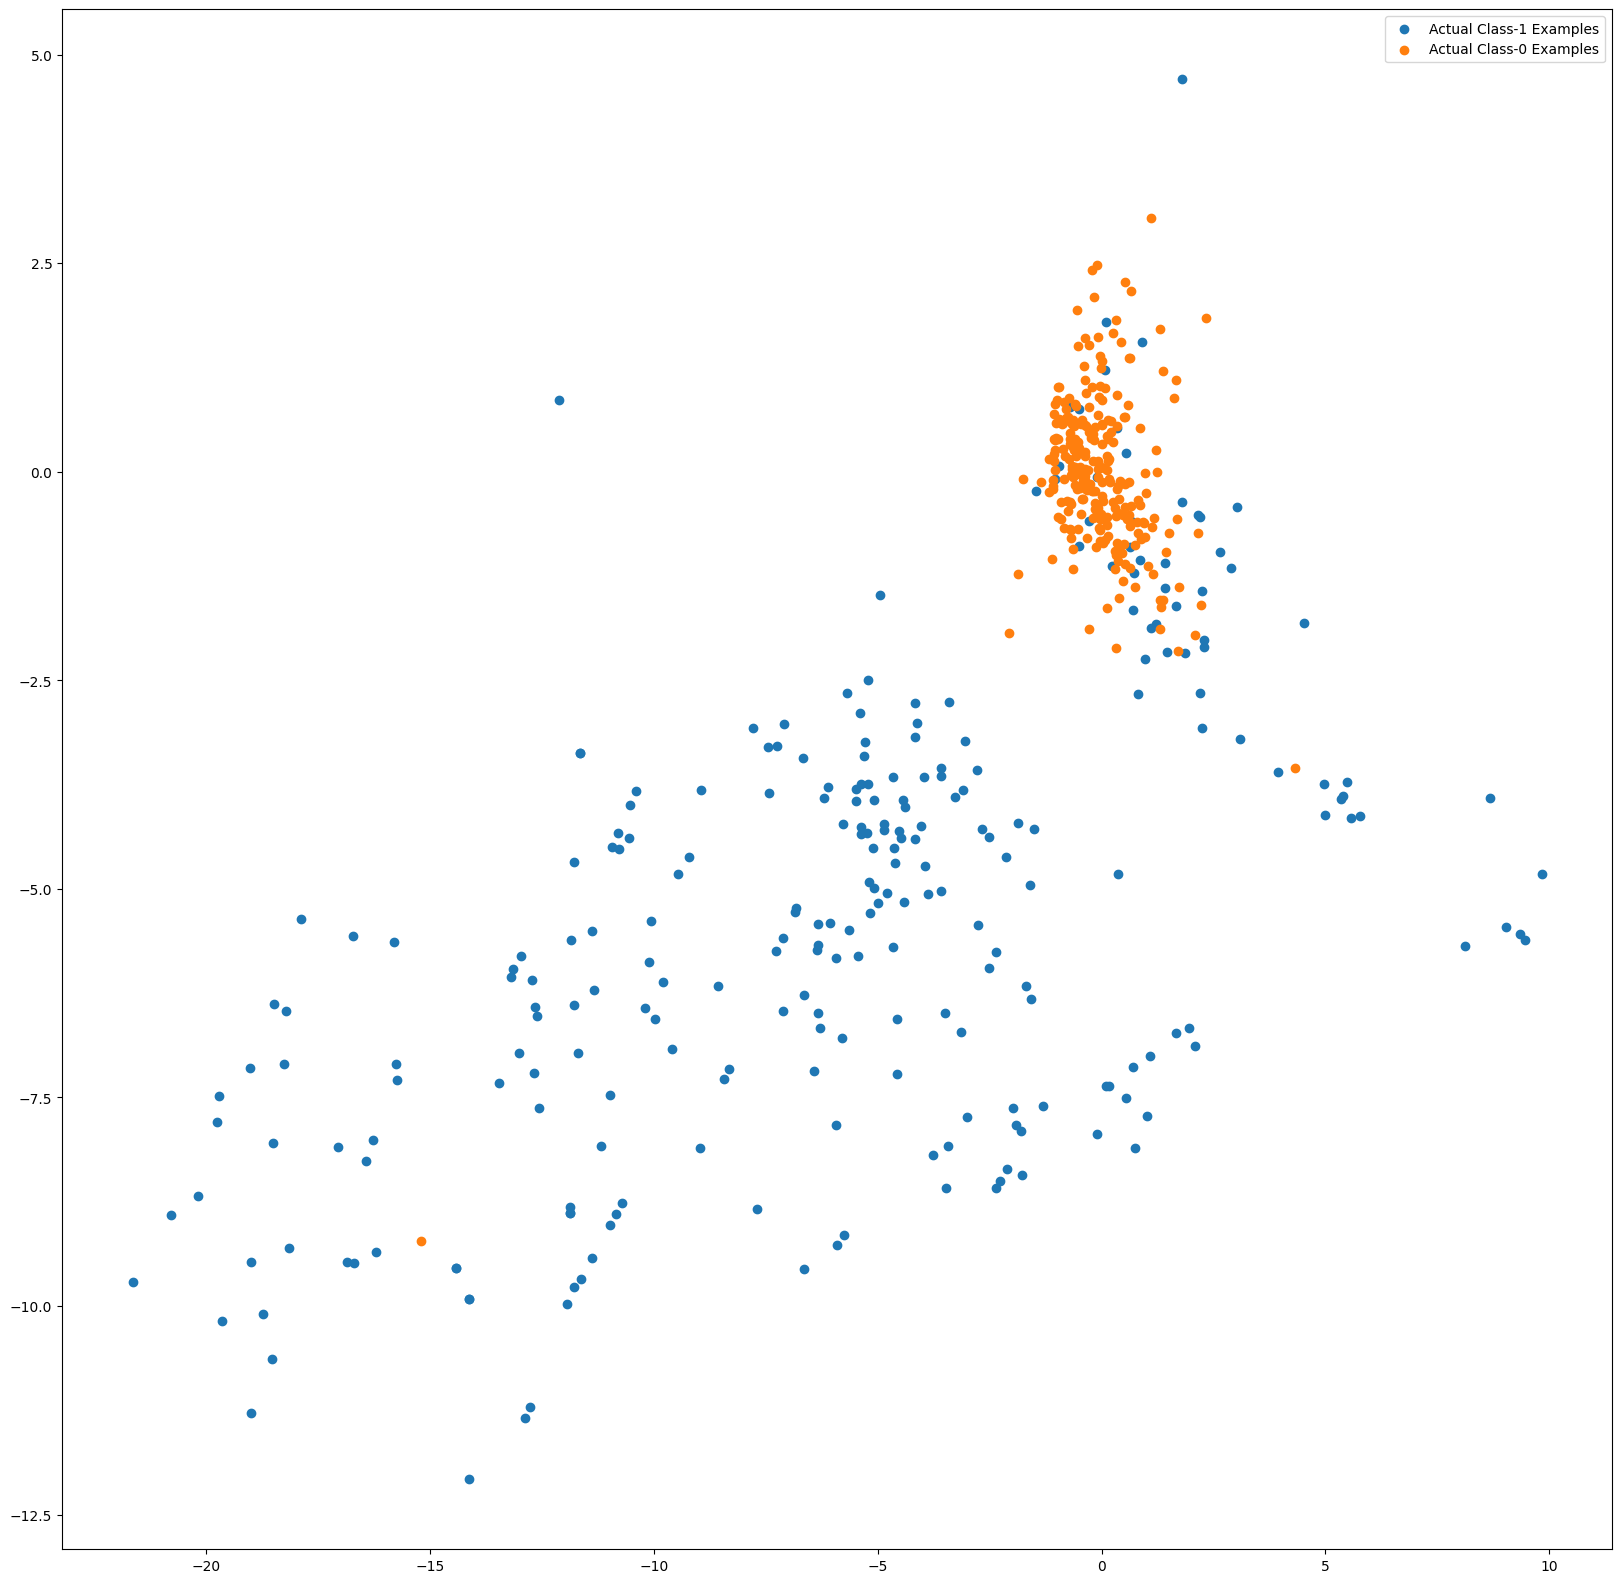

In [29]:
# Assuming 'best_model' is the best trained XGBoost model
var_imp = best_model.feature_importances_

# Find the indices of the top 3 most important features
top_var_indices = np.argsort(var_imp)[::-1][:3]

# Print the names of the top 3 most important features
print('Top 3 most important features:')
for i, idx in enumerate(top_var_indices):
    print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = np.argsort(var_imp)[-1]
second_top_var_index = np.argsort(var_imp)[-2]

X_train_1 = X_train.to_numpy()[np.where(y_train == 1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train == 0.0)]

np.random.shuffle(X_train_0)

plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv
- y_train_cv
- y_test_cv

### Random Oversampling

In [46]:
# Initialize the Random Oversampler
ros = RandomOverSampler(random_state=42)

# Perform Random Oversampling on X_train and y_train
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Print shapes for debugging
print("Shapes after Random Over Sampling:")
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_train_ros.shape:", X_train_ros.shape)
print("y_train_ros.shape:", y_train_ros.shape)

Shapes:
X_train.shape: (139554, 29)
y_train.shape: (139554,)
X_train_ros.shape: (278592, 29)
y_train_ros.shape: (278592,)


In [30]:
### Logistic Regression


In [31]:
# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.linear_model import LogisticRegression
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
# import numpy as np

# Define a list of values for the 'C' hyperparameter
num_C = [0.001, 0.01, 0.1, 1, 10]

# Define the number of desired cross-validation folds
cv_num = 5

# Initialize the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)

# # Initialize the Random Oversampler
# ros = RandomOverSampler(random_state=42)

# # Perform Random Oversampling on X_train and y_train
# X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(logistic_regression, X_train_ros, y_train_ros, cv=cv_num, scoring='roc_auc')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

# Split the data into training and test sets (you can adjust the test_size)
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_ros, y_train_ros, test_size=0.2, random_state=42, stratify=y_train_ros)




Cross-validation scores: [0.94249717 0.94290996 0.94364478 0.94258588 0.94262177]
Mean CV accuracy: 0.9428519135391357


In [47]:
# Print shapes for debugging
print("Shapes after Random Over Sampling:")
print("X_train_cv.shape:", X_train_cv.shape)
print("X_test_cv.shape:", X_test_cv.shape)
print("y_train_cv.shape:", y_train_cv.shape)
print("y_test_cv.shape:", y_test_cv.shape)

Shapes after Random Over Sampling:
X_train_cv.shape: (222873, 29)
X_test_cv.shape: (55719, 29)
y_train_cv.shape: (222873,)
y_test_cv.shape: (55719,)


In [32]:
# Train the Logistic Regression model on the training dataset
logistic_regression.fit(X_train_cv, y_train_cv)

# Make predictions on the test dataset
y_pred_cv = logistic_regression.predict(X_test_cv)

# Calculate ROC AUC
y_prob_cv = logistic_regression.predict_proba(X_test_cv)[:, 1]
roc_auc = roc_auc_score(y_test_cv, y_prob_cv)

# Evaluate the model's performance on the test dataset
accuracy = accuracy_score(y_test_cv, y_pred_cv)
conf_matrix = confusion_matrix(y_test_cv, y_pred_cv)
class_report = classification_report(y_test_cv, y_pred_cv)

# Print evaluation metrics including ROC AUC
print("\nAccuracy on the test dataset:", accuracy)
print("ROC AUC on the test dataset:", roc_auc)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy on the test dataset: 0.942694592508839
ROC AUC on the test dataset: 0.9872216675053772

Confusion Matrix:
 [[27028   832]
 [ 2361 25498]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94     27860
           1       0.97      0.92      0.94     27859

    accuracy                           0.94     55719
   macro avg       0.94      0.94      0.94     55719
weighted avg       0.94      0.94      0.94     55719



### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

In [33]:
# import pandas as pd
# from sklearn.model_selection import cross_val_score
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# import xgboost as xgb
# import time

# List of models
models = [
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    #("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model commented during development phase as it runs longer
    ("XGBoost", xgb.XGBClassifier(random_state=42))
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_score = 0.0
best_params = None

# Initialize a list to store results
results = []

# Progress bar initialization
total_models = len(models)
current_model = 0

# Iterate through models
for model_name, model in models:
    current_model += 1
    print(f"Training {model_name} ({current_model}/{total_models})...")

    start_time = time.time()  # Record start time

    # Perform cross-validation
    scores = cross_val_score(model, X_train_cv, y_train_cv, cv=5, scoring='roc_auc')

    end_time = time.time()  # Record end time
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Calculate mean ROC AUC score
    mean_score = scores.mean()

    print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

    # Check if this model is the best so far
    if mean_score > best_score:
        best_score = mean_score
        best_model = model_name
        best_params = model.get_params()  # Get the best hyperparameters

    # Store results in the list
    results.append({
        'model_name': model_name,
        'best_score': mean_score,
        'best_params': model.get_params(),
        'time_taken': elapsed_time
    })

print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")

# Create a dataframe from the results list
results_df = pd.DataFrame(results)

# Print the dataframe
print("\nResults DataFrame:")
print(results_df)


Training K-Nearest Neighbors (1/4)...
K-Nearest Neighbors - Mean ROC AUC: 0.9998, Time Taken: 54.02 seconds
Training Decision Tree (2/4)...
Decision Tree - Mean ROC AUC: 0.9997, Time Taken: 23.37 seconds
Training Random Forest (3/4)...
Random Forest - Mean ROC AUC: 1.0000, Time Taken: 341.41 seconds
Training XGBoost (4/4)...
XGBoost - Mean ROC AUC: 1.0000, Time Taken: 94.77 seconds

Best Model: Random Forest with ROC AUC score of 1.0000

Results DataFrame:
            model_name  best_score  \
0  K-Nearest Neighbors    0.999812   
1        Decision Tree    0.999686   
2        Random Forest    1.000000   
3              XGBoost    0.999974   

                                         best_params  time_taken  
0  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   54.019087  
1  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   23.371157  
2  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  341.414878  
3  {'objective': 'binary:logistic', 'use_label_en...   94.773112  


In [34]:
results_df

,model_name,best_score,best_params,time_taken
0,K-Nearest Neighbors,0.999812,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",54.019087
1,Decision Tree,0.999686,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",23.371157
2,Random Forest,1.000000,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",341.414878
3,XGBoost,0.999974,"{'objective': 'binary:logistic', 'use_label_en...",94.773112


In [35]:
# Update the code to use X_train_cv, y_train_cv, X_test_cv, and y_test_cv for train and test splits

models_to_explore = [
    {
        'model_name': 'XGBoost',
        'model': XGBClassifier(),
        'param_grid': {
            'n_estimators': [100],  # value taken from the best param
            'max_depth': [3, 4, 5],  # the next values are randomly chosen
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_roc_auc = 0.0

# Create a tqdm progress bar for hyperparameter tuning
progress_bar = tqdm(total=len(models_to_explore), desc="Exploring Models")

for model_info in models_to_explore:
    model_name = model_info['model_name']
    model = model_info['model']
    param_grid = model_info['param_grid']

    folds = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=folds,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Fit the model with hyperparameter tuning on the training data
    start_time = time.time()
    grid_search.fit(X_train_cv, y_train_cv)  # Use X_train_cv and y_train_cv
    end_time = time.time()

    # Calculate execution time for this model exploration
    execution_time = end_time - start_time

    # Get the best model
    best_model_for_current = grid_search.best_estimator_

    # Evaluate the best model on the validation data (X_test_cv and y_test_cv)
    y_pred = best_model_for_current.predict_proba(X_test_cv)[:, 1]  # Use X_test_cv and y_test_cv
    roc_auc = roc_auc_score(y_test_cv, y_pred)  # Use X_test_cv and y_test_cv

    print(f"{model_name} - ROC AUC on Validation Data: {roc_auc:.4f}")

    if roc_auc > best_roc_auc:
        best_model = best_model_for_current
        best_roc_auc = roc_auc

    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Train the best model on the full training data (X_train_cv and y_train_cv)
best_model.fit(X_train_cv, y_train_cv)

# Evaluate the best model on the test data (X_test_cv and y_test_cv)
y_pred = best_model.predict_proba(X_test_cv)[:, 1]  # Use X_test_cv and y_test_cv
roc_auc = roc_auc_score(y_test_cv, y_pred)  # Use X_test_cv and y_test_cv
print(f"Best Model ({best_model.__class__.__name__}) - ROC AUC on Test Data: {roc_auc:.4f}")

# Assuming 'best_model' is the best trained XGBoost model
var_imp = best_model.feature_importances_

# Find the indices of the top 3 most important features
top_var_indices = np.argsort(var_imp)[::-1][:3]

# Print the names of the top 3 most important features
print('Top 3 most important features:')
for i, idx in enumerate(top_var_indices):
    print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


Exploring Models:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Exploring Models: 100%|██████████| 1/1 [10:36<00:00, 636.45s/it]

XGBoost - ROC AUC on Validation Data: 1.0000


Best Model (XGBClassifier) - ROC AUC on Test Data: 1.0000
Top 3 most important features:
1: Feature 13, Importance: 0.5077784061431885
2: Feature 7, Importance: 0.05642770230770111
3: Feature 3, Importance: 0.054680660367012024


Check the above code if correct variables are used in predicting and plotting. Action Item for me - 9/20/2023

### Print the class distribution after applying SMOTE

In [36]:
# pip install imbalanced-learn


Shapes:
X_train.shape: (139554, 29)
y_train.shape: (139554,)
X_train_smote.shape: (278592, 29)


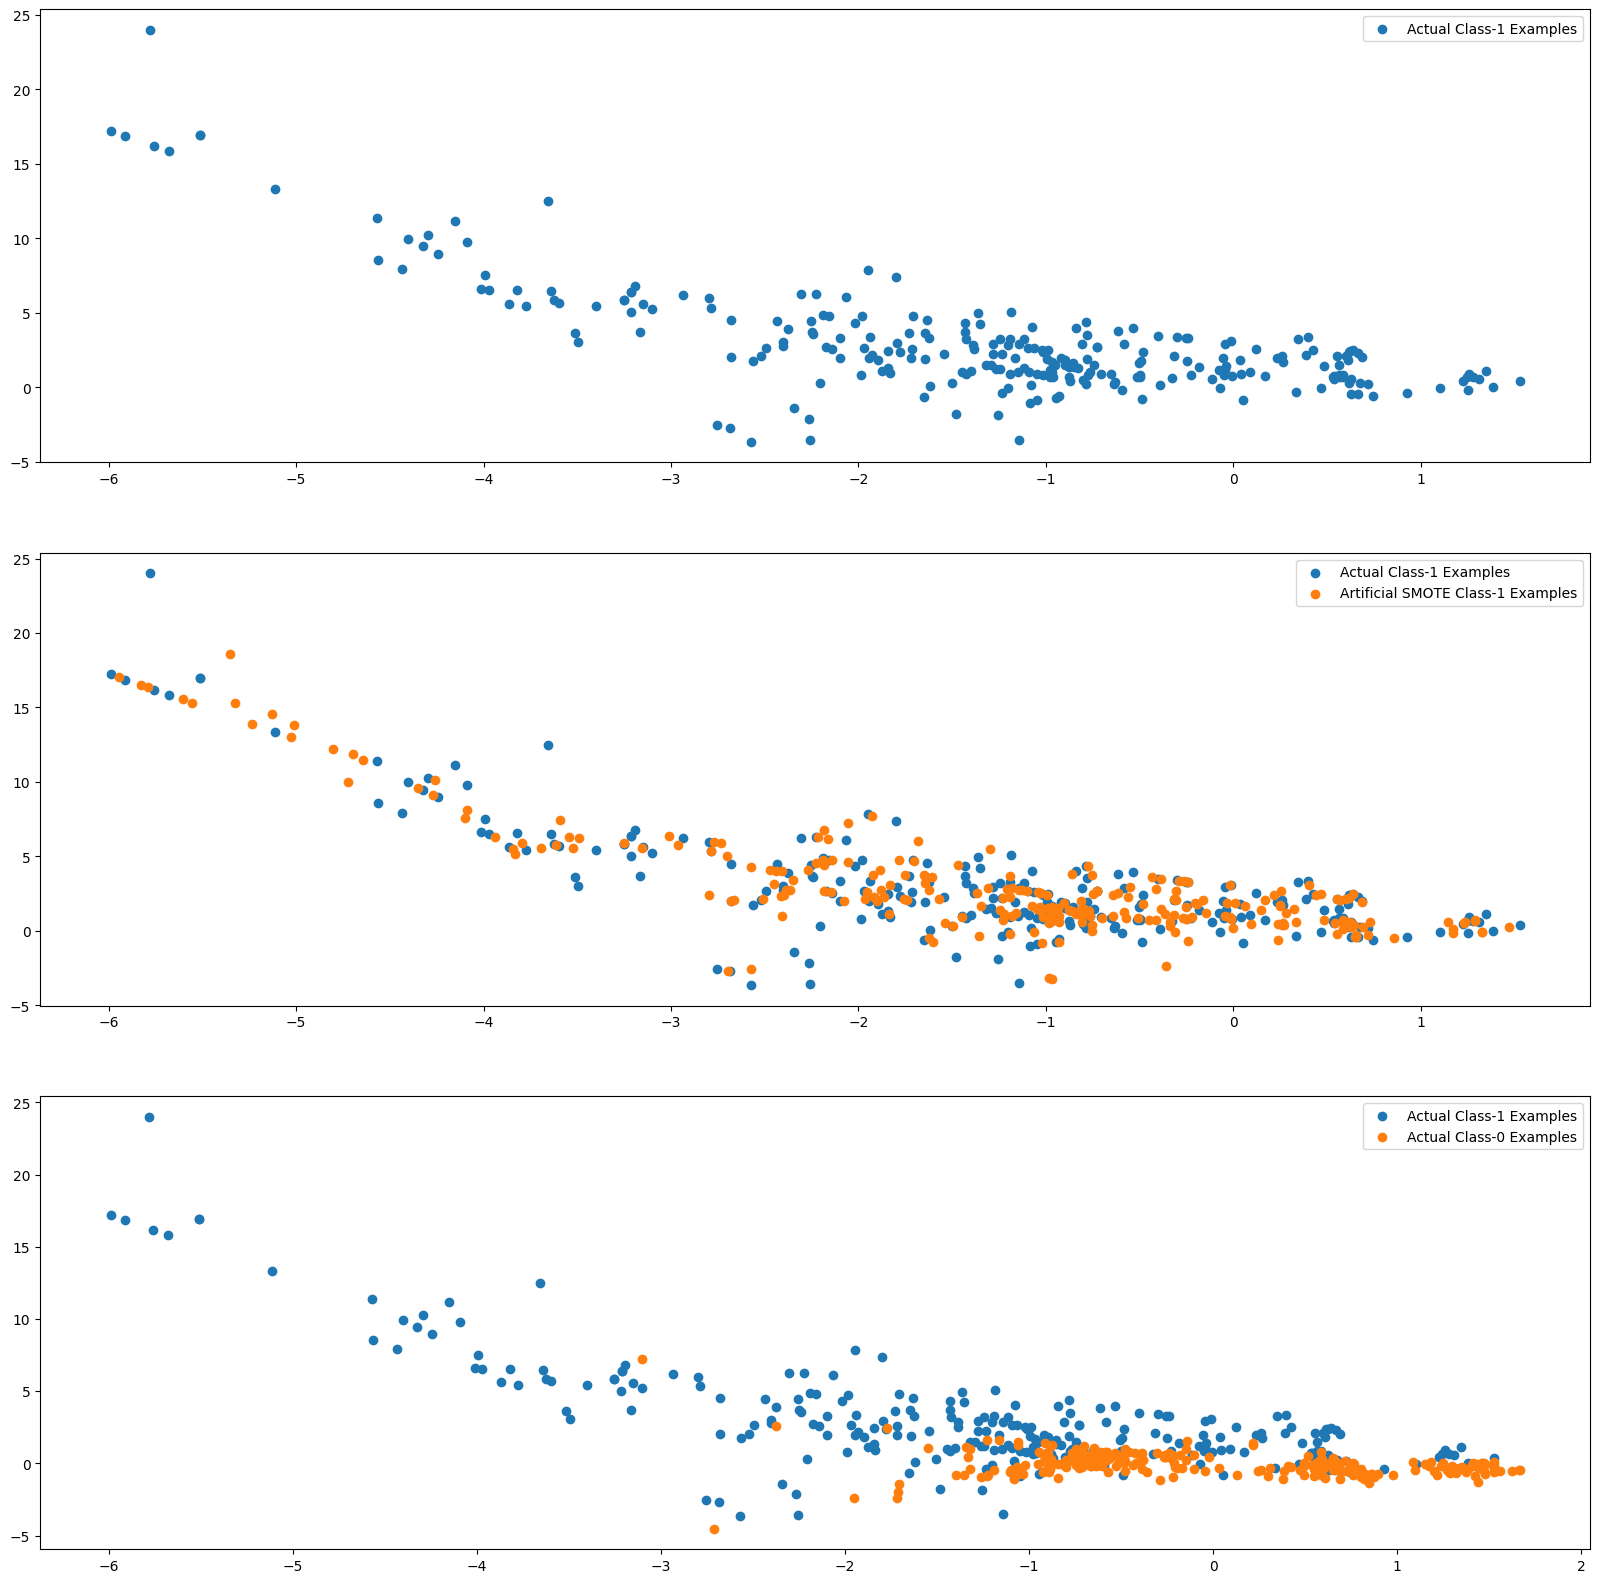

In [37]:
import warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np

warnings.filterwarnings("ignore")

try:
    sm = SMOTE(random_state=0)
    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

    # Print shapes for debugging
    print("Shapes:")
    print("X_train.shape:", X_train.shape)
    print("y_train.shape:", y_train.shape)
    print("X_train_smote.shape:", X_train_smote.shape)

    # Check if X_train_smote has at least one more row than X_train
    if X_train_smote.shape[0] <= X_train.shape[0]:
        raise ValueError("SMOTE did not generate additional samples.")

    # Artificial minority samples and corresponding minority labels from SMOTE are appended
    # below X_train and y_train respectively
    # So to exclusively get the artificial minority samples from SMOTE, we do
    X_train_smote_1 = X_train_smote.iloc[X_train.shape[0]:]  # Use DataFrame indexing here

    X_train_1 = X_train.to_numpy()[np.where(y_train == 1.0)]
    X_train_0 = X_train.to_numpy()[np.where(y_train == 0.0)]

    plt.rcParams['figure.figsize'] = [20, 20]
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_smote_1.iloc[:X_train_1.shape[0], 0], X_train_smote_1.iloc[:X_train_1.shape[0], 1],
                label='Artificial SMOTE Class-1 Examples')  # Use DataFrame indexing here
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
    plt.legend()

    # Calculate and print the share of X_train_1 and X_train_0
    print(f"Share of X_train_1: {X_train_1:.4f}")
    print(f"Share of X_train_0: {X_train_0:.4f}")


except Exception as e:
    print("An error occurred:", str(e))


In [52]:
# Create a logistic regression model
logistic_regression = LogisticRegression()

# Perform cross-validation with ROC-AUC scoring
cv_scores = cross_val_score(logistic_regression, X_train_smote, y_train_smote, cv=cv_num, scoring='roc_auc')

# Print the cross-validation scores
print("Cross-Validation ROC-AUC Scores:", cv_scores)

# Calculate and print the mean and standard deviation of the ROC-AUC scores
mean_roc_auc = cv_scores.mean()
std_roc_auc = cv_scores.std()
print(f"Mean ROC-AUC: {mean_roc_auc:.4f}")
print(f"Standard Deviation of ROC-AUC: {std_roc_auc:.4f}")

# Split the data into training and test sets (you can adjust the test_size)
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=42, stratify=y_train_smote)


Cross-Validation ROC-AUC Scores: [0.98897271 0.98893431 0.98926397 0.9893442  0.98910013]
Mean ROC-AUC: 0.9891
Standard Deviation of ROC-AUC: 0.0002


In [38]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using SMOTE

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


In [39]:
# # import time #Used for timing the execution of each model.
# # from sklearn.model_selection import cross_val_score #Used for performing cross-validation and evaluating model performance.
# # from sklearn.neighbors import KNeighborsClassifier
# # from sklearn.tree import DecisionTreeClassifier
# # from sklearn.ensemble import RandomForestClassifier
# # from sklearn.svm import SVC
# # import xgboost as xgb

# # List of models - is a list that contains tuples, where each tuple consists of a model name and an instance of a classifier.
# models = [
#     ("K-Nearest Neighbors", KNeighborsClassifier()),
#     ("Decision Tree", DecisionTreeClassifier(random_state=42)),
#     ("Random Forest", RandomForestClassifier(random_state=42)),
# #    ("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model exclued as it takes too long to run
#     ("XGBoost", xgb.XGBClassifier(random_state=42))
# ]

# # Initialize variables for storing the best model and its evaluation score
# best_model = None
# best_score = 0.0

# # Progress bar initialization
# total_models = len(models)
# current_model = 0

# # Iterate through models
# for model_name, model in models:
#     current_model += 1
#     print(f"Training {model_name} ({current_model}/{total_models})...")

#     start_time = time.time()

#     # Perform cross-validation
#     scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')

#     end_time = time.time()
#     elapsed_time = end_time - start_time

#     # Calculate mean ROC AUC score
#     mean_score = scores.mean()

#     print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

#     # Check if this model is the best so far
#     if mean_score > best_score:
#         best_score = mean_score
#         best_model = model_name

# print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")


Training K-Nearest Neighbors (1/4)...
K-Nearest Neighbors - Mean ROC AUC: 0.9996, Time Taken: 86.02 seconds
Training Decision Tree (2/4)...
Decision Tree - Mean ROC AUC: 0.9982, Time Taken: 82.34 seconds
Training Random Forest (3/4)...
Random Forest - Mean ROC AUC: 1.0000, Time Taken: 863.04 seconds
Training XGBoost (4/4)...
XGBoost - Mean ROC AUC: 1.0000, Time Taken: 205.74 seconds

Best Model: XGBoost with ROC AUC score of 1.0000


In [ ]:
# List of models - revised code
models = [
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
#    ("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model added here
    ("XGBoost", xgb.XGBClassifier(random_state=42))
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_score = 0.0

# Progress bar initialization
total_models = len(models)
current_model = 0

# Iterate through models
for model_name, model in models:
    current_model += 1
    print(f"Training {model_name} ({current_model}/{total_models})...")

    start_time = time.time()

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_cv, y_train_cv, cv=5, scoring='roc_auc')

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Calculate mean ROC AUC score
    mean_score = cv_scores.mean()

    print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

    # Check if this model is the best so far
    if mean_score > best_score:
        best_score = mean_score
        best_model = model_name

print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")


##### Build models on other algorithms to see the better performing on SMOTE

In [ ]:
# code for tuning - pending

### Print the class distribution after applying ADASYN

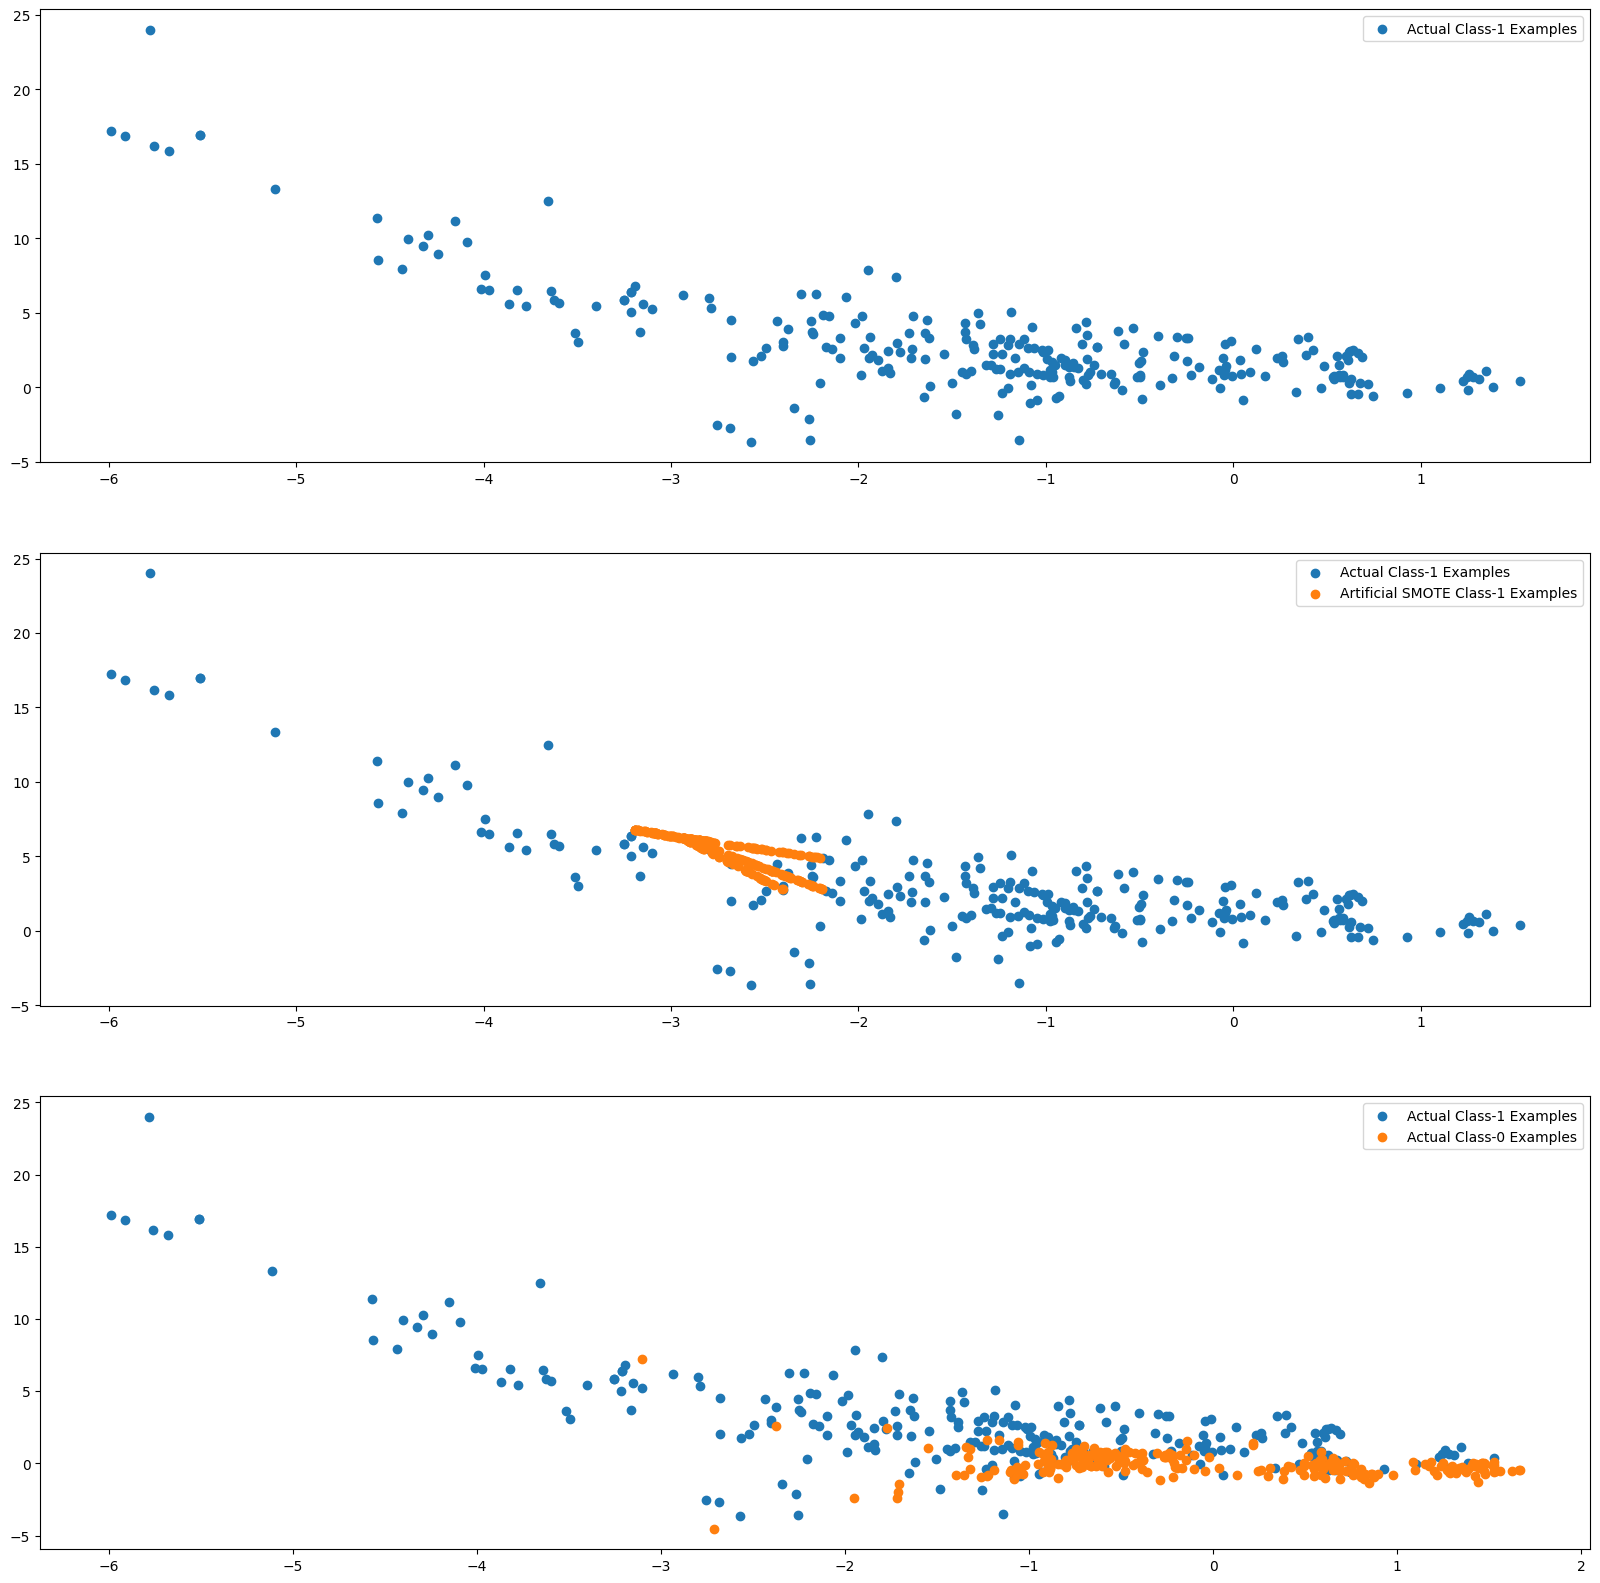

In [41]:
# import warnings
# warnings.filterwarnings("ignore")

# from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
#plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1], label='Artificial ADASYN Class-1 Examples')
plt.scatter(X_train_adasyn_1.iloc[:X_train_1.shape[0], 0], X_train_adasyn_1.iloc[:X_train_1.shape[0], 1], label='Artificial SMOTE Class-1 Examples')  # Use DataFrame indexing here
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [53]:

# Print shapes for debugging
print("Shapes:")
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_train_adasyn.shape:", X_train_adasyn.shape)

# Check if X_train_adasyn has at least one more row than X_train
if X_train_adasyn.shape[0] <= X_train.shape[0]:
    raise ValueError("ADASYN did not generate additional samples.")

# Perform cross-validation
cv_scores = cross_val_score(logistic_regression, X_train_adasyn, y_train_adasyn, cv=cv_num, scoring='roc_auc')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV ROC AUC:", np.mean(cv_scores))

# Split the data into training and test sets (you can adjust the test_size)
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_adasyn, y_train_adasyn, test_size=0.2, random_state=42, stratify=y_train_adasyn)


Shapes:
X_train.shape: (139554, 29)
y_train.shape: (139554,)
X_train_adasyn.shape: (278562, 29)
Cross-validation scores: [0.89398005 0.88844584 0.97895364 0.96207651 0.89309854]
Mean CV ROC AUC: 0.9233109164761476


In [42]:
# check if the underlying scatterplot data matches with raw data - action item for me - 9/20/2023

In [43]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using ADASYN

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


In [44]:
# # import time
# # from sklearn.model_selection import cross_val_score
# # from sklearn.neighbors import KNeighborsClassifier
# # from sklearn.tree import DecisionTreeClassifier
# # from sklearn.ensemble import RandomForestClassifier
# # from sklearn.svm import SVC
# # import xgboost as xgb

# # List of models
# models = [
#     ("K-Nearest Neighbors", KNeighborsClassifier()),
#     ("Decision Tree", DecisionTreeClassifier(random_state=42)),
#     ("Random Forest", RandomForestClassifier(random_state=42)),
# #    ("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model added here
#     ("XGBoost", xgb.XGBClassifier(random_state=42))
# ]

# # Initialize variables for storing the best model and its evaluation score
# best_model = None
# best_score = 0.0

# # Progress bar initialization
# total_models = len(models)
# current_model = 0

# # Iterate through models
# for model_name, model in models:
#     current_model += 1
#     print(f"Training {model_name} ({current_model}/{total_models})...")

#     start_time = time.time()

#     # Perform cross-validation
#     scores = cross_val_score(model, X_train_adasyn, y_train_adasyn, cv=5, scoring='roc_auc')

#     end_time = time.time()
#     elapsed_time = end_time - start_time

#     # Calculate mean ROC AUC score
#     mean_score = scores.mean()

#     print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

#     # Check if this model is the best so far
#     if mean_score > best_score:
#         best_score = mean_score
#         best_model = model_name

# print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")


Training K-Nearest Neighbors (1/4)...
K-Nearest Neighbors - Mean ROC AUC: 0.9792, Time Taken: 85.05 seconds
Training Decision Tree (2/4)...
Decision Tree - Mean ROC AUC: 0.9004, Time Taken: 101.65 seconds
Training Random Forest (3/4)...
Random Forest - Mean ROC AUC: 0.9876, Time Taken: 971.08 seconds
Training XGBoost (4/4)...
XGBoost - Mean ROC AUC: 0.9940, Time Taken: 205.42 seconds

Best Model: XGBoost with ROC AUC score of 0.9940


In [55]:
# List of models
models = [
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
#    ("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model added here
    ("XGBoost", xgb.XGBClassifier(random_state=42))
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_score = 0.0

# Progress bar initialization
total_models = len(models)
current_model = 0

# Split the data into training and test sets (you can adjust the test_size)
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_adasyn, y_train_adasyn, test_size=0.2, random_state=42, stratify=y_train_adasyn)

# Iterate through models
for model_name, model in models:
    current_model += 1
    print(f"Training {model_name} ({current_model}/{total_models})...")

    start_time = time.time()

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_cv, y_train_cv, cv=5, scoring='roc_auc')

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Calculate mean ROC AUC score
    mean_score = cv_scores.mean()

    print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

    # Check if this model is the best so far
    if mean_score > best_score:
        best_score = mean_score
        best_model = model_name

print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")


Training K-Nearest Neighbors (1/4)...
K-Nearest Neighbors - Mean ROC AUC: 0.9995, Time Taken: 55.49 seconds
Training Decision Tree (2/4)...
Decision Tree - Mean ROC AUC: 0.9981, Time Taken: 77.18 seconds
Training Random Forest (3/4)...
Random Forest - Mean ROC AUC: 1.0000, Time Taken: 686.48 seconds
Training XGBoost (4/4)...
XGBoost - Mean ROC AUC: 1.0000, Time Taken: 171.53 seconds

Best Model: Random Forest with ROC AUC score of 1.0000


##### Build models on other algorithms to see the better performing on ADASYN

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [ ]:
# # modified version to run on a smaller dataset - 9/19/2023
# from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# from xgboost import XGBClassifier
# from sklearn.metrics import roc_auc_score
# from tqdm import tqdm
# import time

# # Assuming X and y are your full dataset, you can select the first 1000 records
# #X_subset = X_train[:1000]
# #y_subset = y_train[:1000]

# # Split the data into train, validation, and test sets
# #X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
# #X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# models_to_explore = [
#     {
#         'model_name': 'XGBoost',
#         'model': XGBClassifier(),
#         'param_grid': {
#             'n_estimators': [100, 200, 300],
#             'max_depth': [3, 4, 5],
#             'learning_rate': [0.01, 0.1, 0.2]
#         }
#     },
# ]

# # Initialize variables for storing the best model and its evaluation score
# best_model = None
# best_roc_auc = 0.0

# # Create a tqdm progress bar for hyperparameter tuning
# progress_bar = tqdm(total=len(models_to_explore), desc="Exploring Models")

# for model_info in models_to_explore:
#     model_name = model_info['model_name']
#     model = model_info['model']
#     param_grid = model_info['param_grid']

#     folds = KFold(n_splits=5, shuffle=True, random_state=42)

#     # Perform hyperparameter tuning using GridSearchCV
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid,
#         scoring='roc_auc',
#         cv=folds,
#         n_jobs=-1,
#         verbose=1,
#         return_train_score=True
#     )

#     # Fit the model with hyperparameter tuning
#     start_time = time.time()
#     grid_search.fit(X_train_adasyn, y_train_adasyn)  # Replace with your actual variable names
#     end_time = time.time()

#     # Calculate execution time for this model exploration
#     execution_time = end_time - start_time

#     # Get the best model
#     best_model_for_current = grid_search.best_estimator_

#     # Evaluate the best model on the validation data
#     y_pred = best_model_for_current.predict_proba(X_val)[:, 1]  # Replace with your actual variable names
#     roc_auc = roc_auc_score(y_val, y_pred)  # Replace with your actual variable names

#     print(f"{model_name} - ROC AUC on Validation Data: {roc_auc:.4f}")

#     if roc_auc > best_roc_auc:
#         best_model = best_model_for_current
#         best_roc_auc = roc_auc

#     # Update the progress bar
#     progress_bar.update(1)

# # Close the progress bar
# progress_bar.close()

# # Train the best model on the full training data
# best_model.fit(X_train, y_train)  # Replace with your actual variable names

# # Evaluate the best model on the test data
# y_pred = best_model.predict_proba(X_test)[:, 1]  # Replace with your actual variable names
# roc_auc = roc_auc_score(y_test, y_pred)  # Replace with your actual variable names
# print(f"Best Model ({best_model.__class__.__name__}) - ROC AUC on Test Data: {roc_auc:.4f}")

# # Assuming 'best_model' is the best trained XGBoost model
# var_imp = best_model.feature_importances_

# # Find the indices of the top 3 most important features
# top_var_indices = np.argsort(var_imp)[::-1][:3]

# # Print the names of the top 3 most important features
# print('Top 3 most important features:')
# for i, idx in enumerate(top_var_indices):
#     print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


# # Variable on Index-16 and Index-13 seems to be the top 2 variables
# top_var_index = np.argsort(var_imp)[-1]
# second_top_var_index = np.argsort(var_imp)[-2]

# X_train_1 = X_train.to_numpy()[np.where(y_train == 1.0)]
# X_train_0 = X_train.to_numpy()[np.where(y_train == 0.0)]

# np.random.shuffle(X_train_0)

# plt.rcParams['figure.figsize'] = [20, 20]

# plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
# plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
#             label='Actual Class-0 Examples')
# plt.legend()
# plt.show()

In [57]:
import time
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# Assuming X and y are your full dataset, you can select the first 1000 records
#X_subset = X_train[:1000]
#y_subset = y_train[:1000]

# Split the data into train, validation, and test sets
#X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Split the data into training and test sets with X_train_adasyn and y_train_adasyn
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_adasyn, y_train_adasyn, test_size=0.2, random_state=42, stratify=y_train_adasyn)

models_to_explore = [
    {
        'model_name': 'XGBoost',
        'model': XGBClassifier(),
        'param_grid': {
            'n_estimators': [100],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_roc_auc = 0.0

# Create a tqdm progress bar for hyperparameter tuning
progress_bar = tqdm(total=len(models_to_explore), desc="Exploring Models")

for model_info in models_to_explore:
    model_name = model_info['model_name']
    model = model_info['model']
    param_grid = model_info['param_grid']

    folds = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=folds,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Fit the model with hyperparameter tuning using the training set
    start_time = time.time()
    grid_search.fit(X_train_cv, y_train_cv)  # Use the training set here
    end_time = time.time()

    # Calculate execution time for this model exploration
    execution_time = end_time - start_time

    # Get the best model
    best_model_for_current = grid_search.best_estimator_

    # Evaluate the best model on the test set
    y_pred = best_model_for_current.predict_proba(X_test_cv)[:, 1]  # Use the test set here
    roc_auc = roc_auc_score(y_test_cv, y_pred)  # Use the test set labels here

    print(f"{model_name} - ROC AUC on Test Data: {roc_auc:.4f}")

    if roc_auc > best_roc_auc:
        best_model = best_model_for_current
        best_roc_auc = roc_auc

    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

print(f"\nBest Model: {best_model.__class__.__name__} with ROC AUC score of {best_roc_auc:.4f}")



Exploring Models:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Exploring Models:   0%|          | 0/1 [01:49<?, ?it/s]

Exploring Models: 100%|██████████| 1/1 [14:56<00:00, 896.43s/it]

XGBoost - ROC AUC on Test Data: 1.0000

Best Model: XGBClassifier with ROC AUC score of 1.0000


### Print the important features of the best model to understand the dataset

Top 3 most important features:
1: Feature 13, Importance: 0.23127949237823486
2: Feature 3, Importance: 0.14816153049468994
3: Feature 7, Importance: 0.07402820140123367


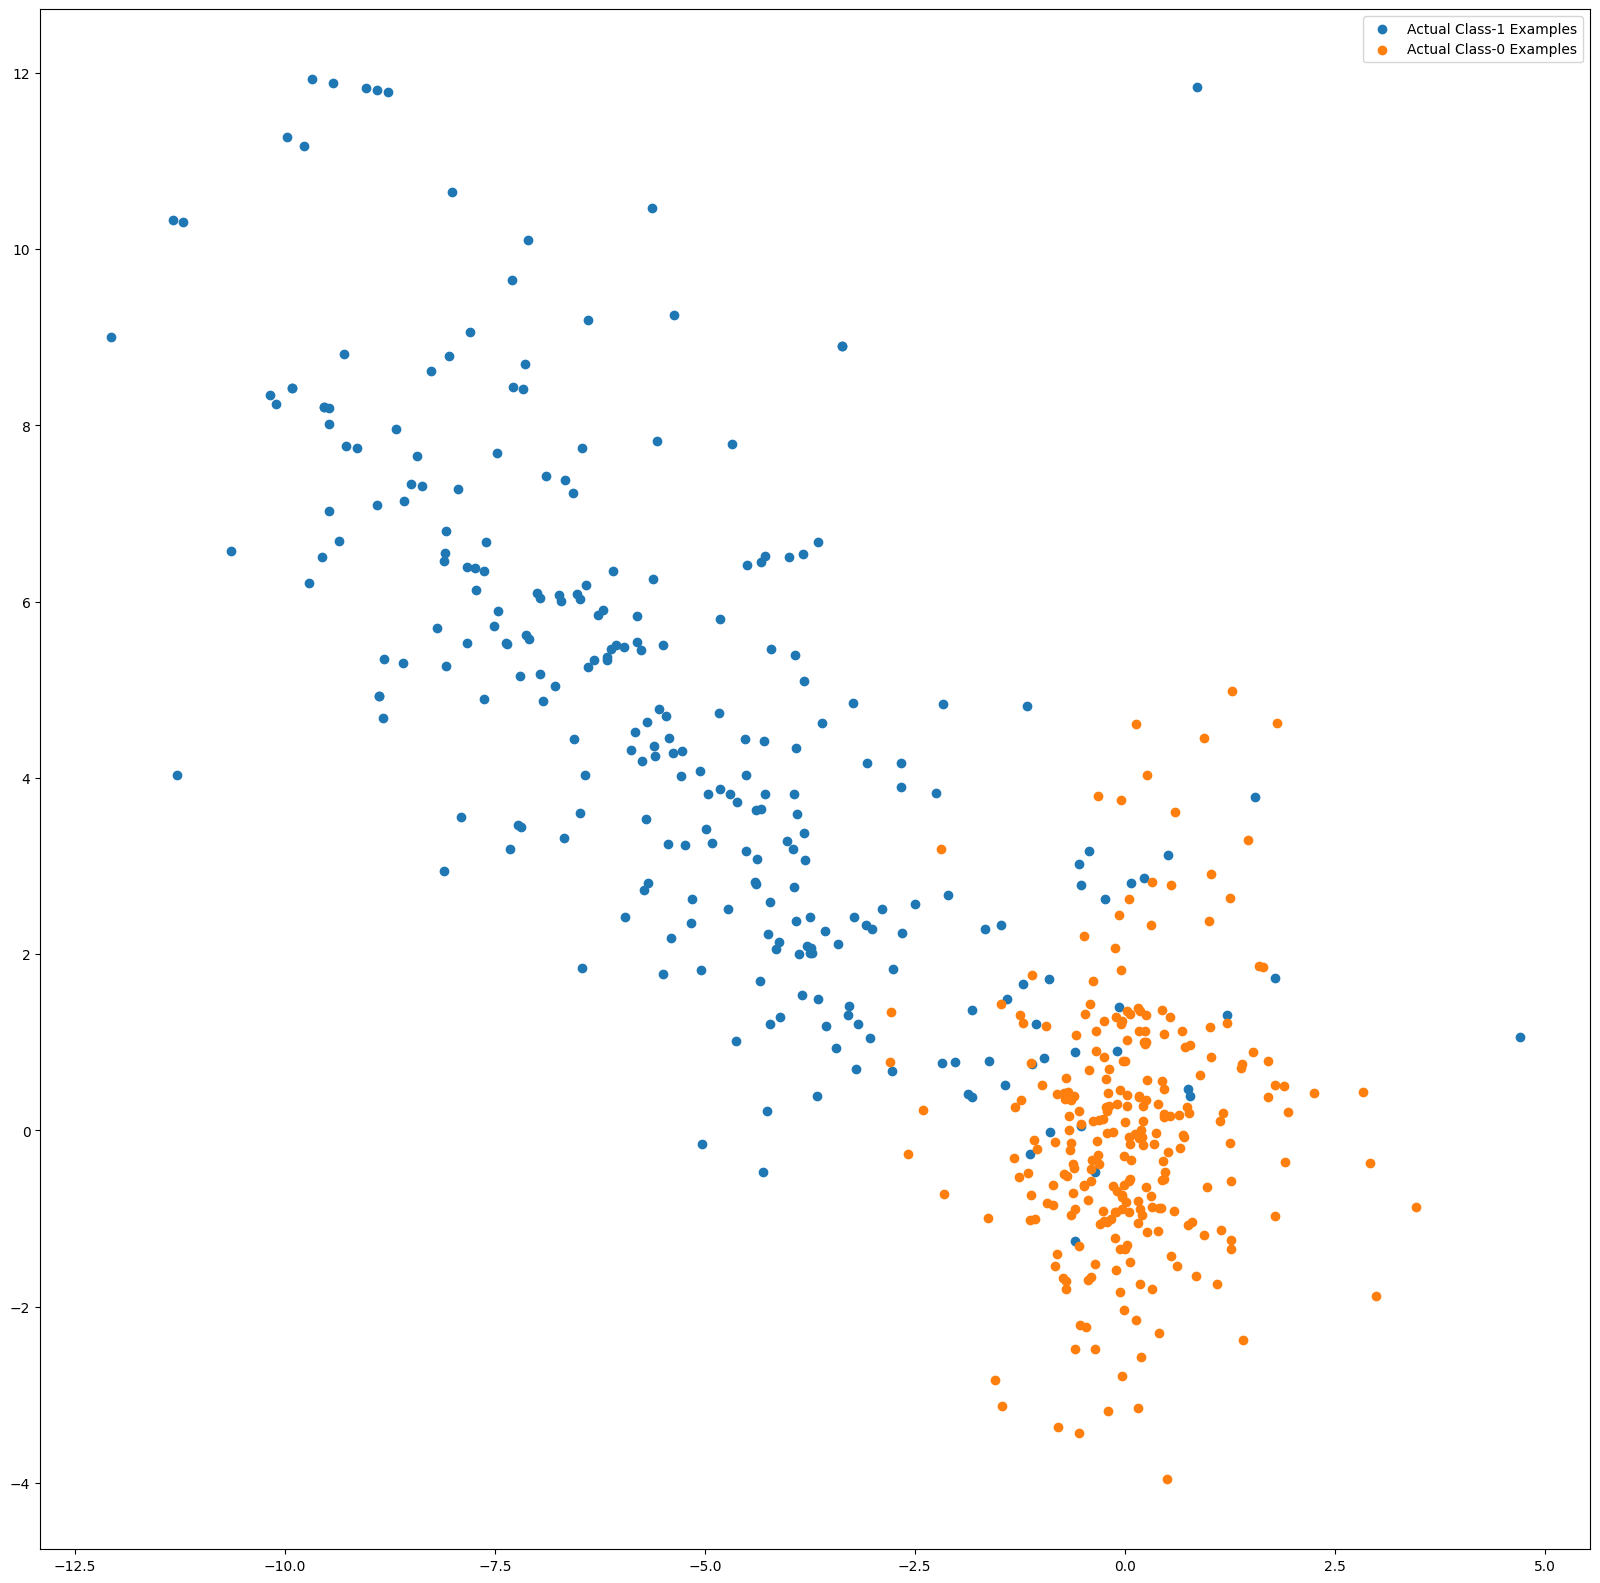

In [58]:
# Assuming 'best_model' is the best trained XGBoost model
var_imp = best_model.feature_importances_

# Find the indices of the top 3 most important features
top_var_indices = np.argsort(var_imp)[::-1][:3]

# Print the names of the top 3 most important features
print('Top 3 most important features:')
for i, idx in enumerate(top_var_indices):
    print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = np.argsort(var_imp)[-1]
second_top_var_index = np.argsort(var_imp)[-2]

X_train_1 = X_train_adasyn.to_numpy()[np.where(y_train == 1.0)]
X_train_0 = X_train_adasyn.to_numpy()[np.where(y_train == 0.0)]

np.random.shuffle(X_train_0)

plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

In [63]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [62]:
from sklearn.metrics import roc_curve

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test_cv, y_pred)

# Find the best threshold that maximizes (TPR - FPR)
best_threshold = thresholds[np.argmax(tpr - fpr)]

# Print the FPR, TPR, and best threshold
print(f"False Positive Rate (FPR): {fpr[np.argmax(tpr - fpr)]:.4f}")
print(f"True Positive Rate (TPR): {tpr[np.argmax(tpr - fpr)]:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")


False Positive Rate (FPR): 0.0004
True Positive Rate (TPR): 1.0000
Best Threshold: 0.8921
